# Using the default resnet

## Imports

In [2]:
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,Subset
from torchvision.models import resnet18
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy

## Parameters

In [3]:
USE_GPU = True
CATALOG_PATH = '../Data/subset_gz1_desi_cross_cat.csv'
DATA_PATH = '../Data/Subset'

In [4]:
#Run processes on CPU or GPU
if USE_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    device = torch.device('cpu')

print('Using device:', device)

NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Using device: cuda


## Importing data

In [5]:
catalog = pd.read_csv(CATALOG_PATH)

#Select only S or Z 
catalog = catalog[catalog['P_EL']<0.8]


print(f"Loaded {catalog.shape[0]} galaxy images")

#Select features (clockwise and anti-clockwise probabilities)
Y = catalog[['P_CW','P_ACW']]
classes = [r'P_CW',r'P_ACW']

Loaded 1000 galaxy images


### Generate list of file locations from catalog

In [6]:
def get_file_paths(catalog_to_convert,folder_path ):
    brick_ids = catalog_to_convert['dr8_id'].str.split("_",expand=True)[0]
    dr8_ids = catalog_to_convert['dr8_id']
    file_locations = folder_path+'/'+brick_ids+'/'+dr8_ids+'.jpg'
    return file_locations

file_locations = get_file_paths(catalog,DATA_PATH)

### Image processing functions

In [7]:
COLOR = True
RAW_SIZE = 15
IMG_SIZE = 160

TARGET_SIZE = 5
TRANSLATE = 0.
ROTATE = False
FLIP = False
LABEL = 2
SHUFFLE = False


def img_proc(img, raw_size=RAW_SIZE, target_size=TARGET_SIZE, translate=TRANSLATE, rotate=ROTATE,
             random_generator=None):
    assert img.shape[-2] == img.shape[-1]
    assert translate >= 0
    
    if random_generator is None:
        random_generator = int.from_bytes(os.urandom(4), byteorder='little')
    rng = np.random.default_rng(random_generator)

    if not isinstance(target_size, (float, int)):
        target_size = rng.uniform(*target_size)
    if rotate:
        assert target_size * (1 + translate) * 2**0.5 < raw_size
        if isinstance(rotate, bool):
            rotate = rng.uniform(0., 360.)
        img = ndimage.rotate(img, rotate, axes=(-1, -2), reshape=False, order=1)
    else:
        assert target_size * (1 + translate) < raw_size
    s = img.shape[-1]
    translate = translate * target_size
    t_x = rng.uniform(-translate, translate) if translate > 0 else 0
    t_y = rng.uniform(-translate, translate) if translate > 0 else 0
    a = int(s * (raw_size - target_size + t_x) / (2 * raw_size))
    b = int(s * (raw_size - target_size + t_y) / (2 * raw_size))
    c = int(s * target_size / raw_size)
    return img[..., a:(a + c), b:(b + c)]


def read_img(path, color=COLOR, img_size=IMG_SIZE, atleast_3d=True, random_flip=FLIP,
             shuffle_channel=SHUFFLE, random_generator=None, **kwargs):
    if random_generator is None:
        random_generator = int.from_bytes(os.urandom(4), byteorder='little')
    rng = np.random.default_rng(random_generator)

    jpeg_file = (np.asarray(Image.open(path)) / 255).astype(np.float32)
    if color:
        img = np.moveaxis(jpeg_file, -1, 0)
        if shuffle_channel:
            if isinstance(shuffle_channel, bool):
                shuffle_channel = rng.permutation(img.shape[0])
            img = img[shuffle_channel]
    else:
        img = np.mean(jpeg_file, axis=-1)
    img = img_proc(img, random_generator=rng, **kwargs)
    rng.uniform(size=100) # just to jump the rng

    if img_size is not None:
        z = img_size / img.shape[-1]
        if img.ndim == 2:
            img = ndimage.zoom(img, (z, z), order=1)
            if atleast_3d:
                img = img[np.newaxis]
        elif img.ndim == 3:
            img = ndimage.zoom(img, (1, z, z), order=1)
        else:
            raise RuntimeError

    if random_flip:
        flip = int(rng.integers(0, 2, 1))
        flip = 2 * flip - 1
    else:
        flip = 1
    return np.ascontiguousarray(img[..., ::flip])

### Reading in images

In [8]:
#Takes 2 mins 20
X = torch.empty(0, 3, 160,160)
for i in range(len(file_locations)):
    X = torch.cat((X, torch.from_numpy(read_img(file_locations[i])).float()[np.newaxis]), 0)

In [9]:
print(f"Processed {X.shape[0]} images")

Processed 1000 images


## Setting up model

In [10]:
selected_model = resnet18(num_classes=2)
if torch.cuda.is_available():
    selected_model.cuda()

### Hyperparameters

In [11]:
learning_rate = 0.01
weight_decay = 1

num_epochs = 120
batch_size = 60 #60

modfile = 'resnet18_modfile.pt'

### Training model function

In [12]:
def train(model, trainloader, optimiser, device):
    train_loss = 0.0
    model.train()

    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)
        optimiser.zero_grad()

        #Calculate train loss
        #Softmax output and labels for passing to cross-entropy function
        p_y = model(data).softmax(dim=1)
        labels = labels.softmax(dim=1).to(device) 

        loss_criterion = nn.CrossEntropyLoss()
        loss = loss_criterion(p_y, labels)
            
        train_loss += loss.item() * data.size(0)
        
        #Feed the loss back
        loss.backward()
        optimiser.step()

    train_loss /= len(trainloader.dataset)
    return train_loss

### Validating model function

In [13]:
def accuracy(true_labels, predicted_labels):
    #Takes in softmaxed labels
    cut = 0.8
    true_labels = true_labels>=cut
    predicted_labels = predicted_labels >= cut
    #metric = MulticlassAccuracy()
    metric = BinaryAccuracy()

    metric.update(true_labels[:,0], predicted_labels[:,0])
    test_accuracy = metric.compute()
    return test_accuracy


#function to test the model on data
def validate(model, testloader, device):
    test_loss = 0.0
    test_accuracy = 0.0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            #Softmax output and labels for passing to cross-entropy function
            p_y = model(data).softmax(dim=1)
            labels = labels.softmax(dim=1).to(device)

            test_accuracy = accuracy(p_y,labels)

            #Calculate test loss         
            loss_criterion = nn.CrossEntropyLoss()
            loss = loss_criterion(p_y, labels)
            test_loss += loss.item() * data.size(0)

        test_loss /= len(testloader.dataset)
        
    return test_loss, test_accuracy

### Split data into train and test

In [14]:
def data_split(frac_val, data):
    dataset_size = len(data)
    nval = int(frac_val*dataset_size)

    indices = list(range(dataset_size))
    train_indices, val_indices = indices[nval:], indices[:nval]

    train_sampler = Subset(data, train_indices)
    valid_sampler = Subset(data, val_indices)

    train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(valid_sampler, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

## Running model

In [15]:
#function to run the entire model train/test loop
TEST_USE = False
early_stopping = True
QUIET = False

def test_train_model(X,Y,model):
    X_tensor = X
    Y_tensor = torch.from_numpy(Y.values).float()

    dataset = TensorDataset(X_tensor, Y_tensor)
    train_loader,val_loader = data_split(0.7,dataset)

    if TEST_USE: #Doesn't currently work
        val_loader, test_loader = data_split(0.5,val_loader)

    #optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)#0.005, #0.01
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.85)

    #array to store metrics
    result_arr = np.zeros((num_epochs,4))

    _bestloss = 1.
    #NN learning
    for epoch in range(num_epochs):
    
        train_loss = train(model, train_loader, optimizer, device)
        val_loss, test_accuracy = validate(model, val_loader, device)
        
        #scheduler.step() 

        if early_stopping and val_loss<_bestloss:
            _bestloss = val_loss
            torch.save(model.state_dict(), modfile)
            best_epoch = epoch

        #set output row
        results = [epoch, train_loss, val_loss,test_accuracy]
        result_arr[epoch] = results

        #print epoch results
        if not QUIET:
            print(f"Epoch: {epoch}, Train Loss: {train_loss:4f}, Validation Loss: {val_loss:4f}, Accuracy: {test_accuracy:4f}, Learning Rate: {optimizer.param_groups[0]['lr']:4f}")
    
    test_arr=[]
    if TEST_USE:
        #Test data run
        bestmodel=selected_model().to(device)
        bestmodel.load_state_dict(torch.load('modfile.pt'))
        test_loss, test_accuracy, test_auc, prediction2,target2,  recall2, f12, precision2 = validate(bestmodel, test_loader, device)
        test_arr=[test_loss, test_accuracy, test_auc, prediction2,target2,  recall2, f12, precision2]

    if not early_stopping:
        torch.save(model.state_dict(), modfile)
        best_epoch = -1

    return result_arr, test_arr, best_epoch

## Actually run model

In [16]:
result_arr1, test_arr1, best_epoch = test_train_model(X,Y,selected_model)

Epoch: 0, Train Loss: 0.623352, Validation Loss: 0.903883, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 1, Train Loss: 0.599914, Validation Loss: 0.903883, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 2, Train Loss: 0.599917, Validation Loss: 0.903883, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 3, Train Loss: 0.599917, Validation Loss: 0.903881, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 4, Train Loss: 0.599915, Validation Loss: 0.903820, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 5, Train Loss: 0.599903, Validation Loss: 0.903450, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 6, Train Loss: 0.599842, Validation Loss: 0.902456, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 7, Train Loss: 0.599557, Validation Loss: 0.898844, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 8, Train Loss: 0.599504, Validation Loss: 0.894658, Accuracy: 1.000000, Learning Rate: 0.010000
Epoch: 9, Train Loss: 0.599396, Validation Loss: 0.880870, Accuracy: 1.00

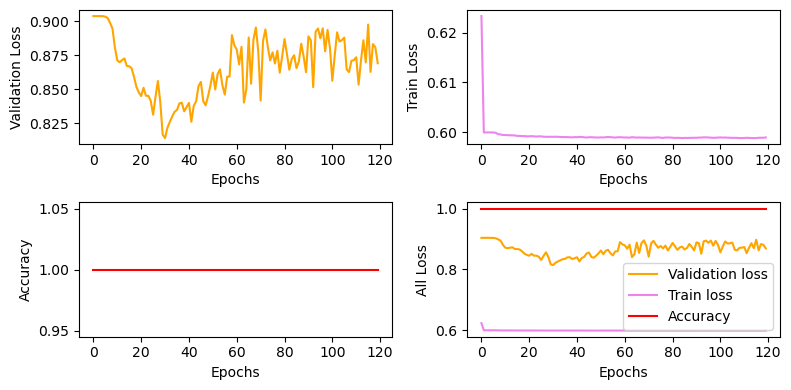

In [17]:
#plot the training cycle
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(221) 
#plt.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', label='Accuracy')
ax1.plot(result_arr1[:,0],result_arr1[:,2],linestyle='-', c='orange',label='Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss')

ax2 = fig.add_subplot(222) 
ax2.plot(result_arr1[:,0],result_arr1[:,1],linestyle='-', c='violet',label='Train loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Train Loss')

ax3 = fig.add_subplot(223) 
ax3.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', c='red',label='Accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')

ax4 = fig.add_subplot(224) 
ax4.plot(result_arr1[:,0],result_arr1[:,2],linestyle='-', c='orange',label='Validation loss')
ax4.plot(result_arr1[:,0],result_arr1[:,1],linestyle='-', c='violet',label='Train loss')
ax4.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', c='red',label='Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('All Loss')
ax4.legend()
plt.tight_layout()
plt.show()